The variance will depend on $x$, and will be a non-linear function, i.e. $\sin(x)$

In [41]:
import torch
import matplotlib.pyplot as plt

## Create Dataset

In [42]:
xs = torch.linspace(0, 35, 200)
vs = xs * torch.cos(xs) + xs

Text(0.5, 0, 'x')

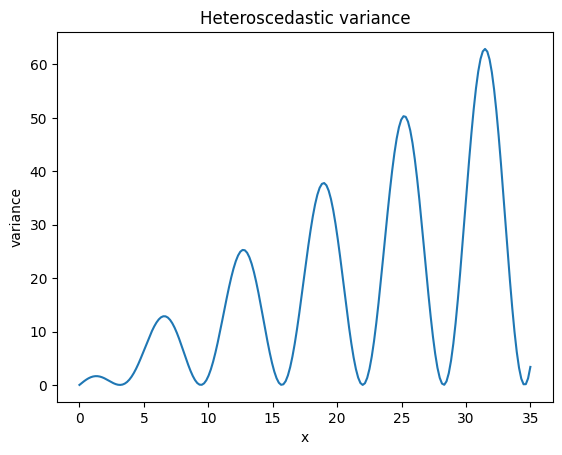

In [43]:
plt.plot(xs, vs)
plt.title("Heteroscedastic variance")
plt.ylabel("variance")
plt.xlabel("x")

In [44]:
torch.manual_seed(0)
n = 100
samples = [torch.normal(mean=0.0, std=vs**0.5) for _ in range(n)]
X = torch.concat([xs] * n).reshape((-1, 1)).cuda()
y = torch.concat(samples).reshape((-1, 1)).cuda()

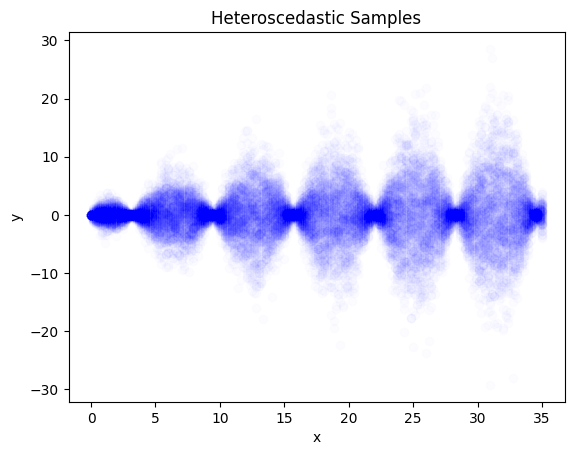

In [45]:
def scatter(X, y, alpha=0.01):
    plt.title("Heteroscedastic Samples")
    plt.ylabel("y")
    plt.xlabel("x")
    plt.scatter(X.cpu(), y.cpu(), color="blue", alpha=alpha)

scatter(X, y)

## Fit a Model
The model $f(x; \theta)$ only outputs the variance of a gaussian distribution, and always assumes a mean $\mu = 0$.

$$ 
\begin{align*}
y &\sim \mathcal{N}(\mu = 0, \sigma^2 = f(x; \theta)) \\
\implies p(y | x) &= \mathcal{N}(0, f(x; \theta))
\end{align*}
$$



Minimizing the negative log-likelyhood for this model means:
$$
\begin{align*}
- \log p(x | x) = - \log \frac{1}{\sigma \sqrt{2\pi}} \exp{ \{ -\frac{y^2}{2\sigma^2} \} }
\end{align*}
$$

In [46]:
from torch import nn

def activation():
    return nn.LeakyReLU()

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        d = 4096
        self.layers = nn.Sequential(
            nn.Linear(in_features=1, out_features=d),
            activation(),
            nn.Linear(in_features=d, out_features=d),
            activation(),
            nn.Linear(in_features=d, out_features=d),
            activation(),
            nn.Linear(in_features=d, out_features=d),
            activation(),
            nn.Linear(in_features=d, out_features=d),
            activation(),
            nn.Linear(in_features=d, out_features=d),
            activation(),
            nn.Linear(in_features=d, out_features=1),
            nn.Softplus()
        )

    def forward(self, x):
        return self.layers(x)

m = Model().cuda()
assert m(X).shape == y.shape

In [47]:
from torch.distributions import Normal

In [48]:
def loss(y, σ):
    return -Normal(loc=0, scale=σ).log_prob(y).sum()

In [49]:
def batch(X, y, size = 256):
    idxs = torch.randint(low=0, high=len(X), size=(size,))
    return X[idxs], y[idxs]

In [50]:
m = Model().cuda()
m.train()
opt = torch.optim.Adam(lr=.0001, params=m.parameters())

for _ in range(200):
    opt.zero_grad()
    X_, y_ = batch(X, y)
    l = loss(y=y_, σ=m(X_))
    if _ % 20 == 0:
        print("loss:", l.item())
    l.backward()
    opt.step()

loss: 4444.576171875
loss: 886.70556640625
loss: 698.7801513671875
loss: 704.88818359375
loss: 688.533935546875
loss: 697.632080078125
loss: 718.49462890625
loss: 680.6524658203125
loss: 717.2883911132812
loss: 708.2342529296875


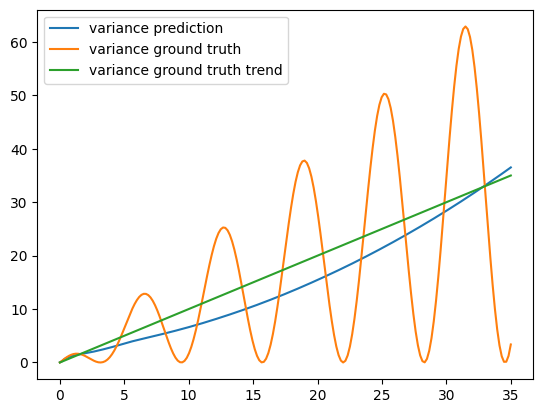

In [51]:
with torch.no_grad():
    preds = m(xs.reshape((-1, 1)).cuda())**2
plt.plot(xs, preds.cpu(), label="variance prediction")
plt.plot(xs, vs, label="variance ground truth")
plt.plot(xs, xs, label="variance ground truth trend")
plt.legend()

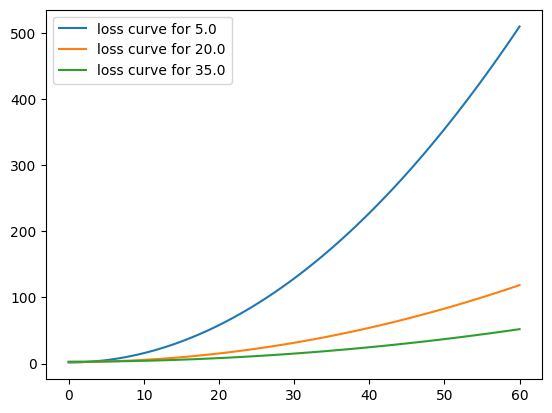

In [52]:
ys = torch.linspace(0., 60, 100)
with torch.no_grad():
    for x in [5., 20., 35.]:
        ps = -Normal(0, m(torch.tensor([x]).cuda())).log_prob(ys.cuda())
        plt.plot(ys, ps.cpu(), label=f"loss curve for {x}")
plt.legend()

# Learng Sinusoidal Curve

In [53]:
m = Model().cuda()
opt = torch.optim.Adam(lr=0.0001, params=m.parameters())
loss = nn.MSELoss()

xs_ = xs.reshape((-1, 1)).cuda()
vs_ = vs.reshape((-1, 1)).cuda()

for _ in range(10):
    opt.zero_grad()
    l = loss(m(xs_), vs_)
    l.backward()
    print("loss:", l.item())
    opt.step()

loss: 561.0269165039062
loss: 484.1649475097656
loss: 296.3088684082031
loss: 288.4075012207031
loss: 223.58712768554688
loss: 221.5966339111328
loss: 241.1984100341797
loss: 233.8854217529297
loss: 215.08656311035156
loss: 216.44085693359375


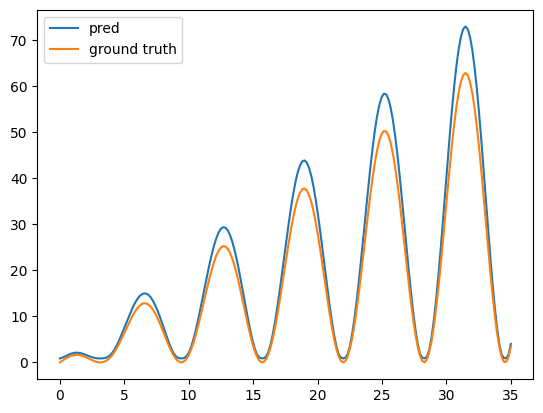

In [54]:
with torch.no_grad():
    plt.plot(xs, m(vs_).cpu(), label="pred")
plt.plot(xs, vs, label="ground truth")
plt.legend()

# Learn Mean and Variance of 2D Gaussian

In [55]:
gt_mu = [1., 3.]
gt_scale = [.2, .1]
dist = Normal(loc=torch.tensor(gt_mu), scale=torch.tensor(gt_scale))
data = dist.sample((100,))

(0.0, 5.0)

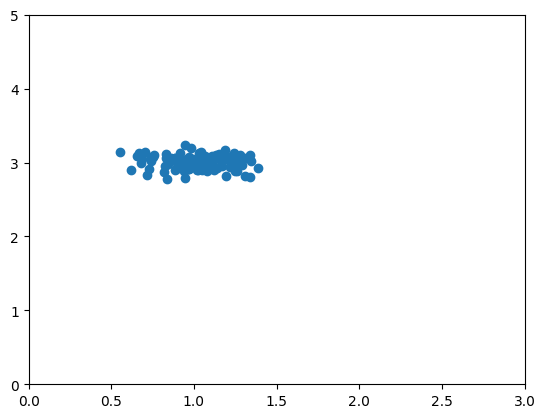

In [56]:
plt.scatter(*data.T)
plt.xlim((0, 3))
plt.ylim((0, 5))

In [57]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.mu = nn.Parameter(torch.randn(2))
        self.scale = nn.Parameter(torch.randn(2) ** 2)
            
    def forward(self):
        return self.mu, self.scale

m = Model2()
_ = m()

In [58]:
m = Model2()
opt = torch.optim.Adam(lr=.1, params=m.parameters())

mus = []
scales = []
for _ in range(300):
    opt.zero_grad()
    mu, scale = m()
    mus.append(mu.detach().clone().numpy())
    scales.append(scale.detach().clone().numpy())
    loss = -Normal(loc=mu, scale=scale).log_prob(data).sum()
    loss.backward()
    if _ % 20 == 0:
        print("loss:", loss.item())
    opt.step()

loss: 3075.39697265625
loss: 319.6318054199219
loss: 199.0355682373047
loss: 170.62265014648438
loss: 155.91587829589844
loss: 144.3712615966797
loss: 134.7873992919922
loss: 126.185791015625
loss: 117.7880859375
loss: 108.78609466552734
loss: 98.19666290283203
loss: 84.5976333618164
loss: 65.3741226196289
loss: 33.65977478027344
loss: -47.9466667175293


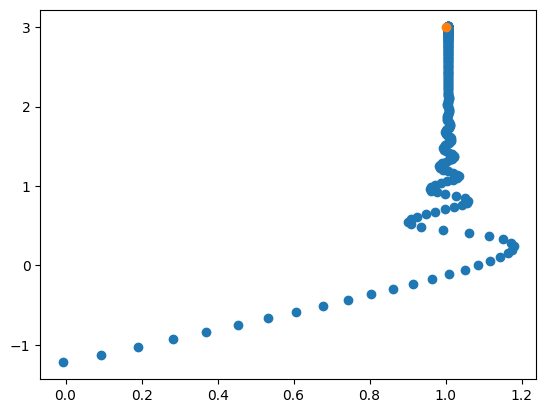

In [59]:
import numpy as np
mus = np.array(mus)
scales = np.array(scales)

plt.scatter(*mus.T)
plt.scatter(*gt_mu)

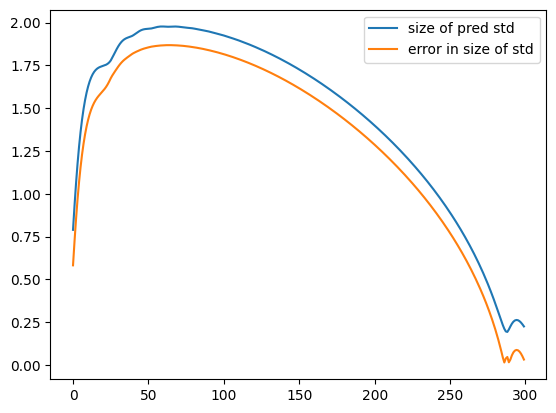

In [60]:
def norm(xs):
    return np.linalg.norm(xs, axis=1)

plt.plot(norm(scales), label="size of pred std")
plt.plot(norm(scales - gt_scale), label="error in size of std")
plt.legend()